
E-E NMDA AMPA
E-I AMPA
I-E GABA
I-I GABA

E-E is i!=j. All others are all to all to begin with.

The goal here is to:  
1. have a PING network with E and I.  
2. add NMDA E-E connection and see how it goes.

In [10]:
from brian2 import *
#import numpy as np
#import matplotlib
import matplotlib.pyplot as plt

In [47]:
start_scope()

defaultclock.dt = 0.02*ms

Ne = 8
Ni = 2
V_I = -80*mV
V_E = 0*mV



# NMDA (excitatory)
g_NMDA_E = 1.0/(Ne-1)*msiemens/cm**2
# g_NMDA_I = 0.258 * nS * 800. / N_E
tausnmdar = 1*ms
tausnmdad = 100*ms
Mg2 = 1.

# some calcium-related vars, table 2
pHC = 4*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6*umolar
thetab = 0.55*umolar
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01*umolar
sigmab = -0.02*umolar
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phi = 0.01
beta = 0.083/ms
chi0 = 0.05*umolar
nbuff = 6.



# E cells stats
Cme = 1*ufarad/cm**2
Ele = -67*mV
ENae = 50*mV
EKe = -100*mV
gle = 0.1*msiemens/cm**2
gNae = 100*msiemens/cm**2
gKe = 80*msiemens/cm**2

# AMPA E-E
gampae = 1.0/(Ne-1)*msiemens/cm**2
ggabae = 0.6/(Ni)*msiemens/cm**2

eqse = '''
dv/dt = ( (gle * (Ele-v) + gNae * m**3 * h * (ENae-v) + gKe * n**4 * (EKe-v) + Isyn + I_NMDA_rec + I))/Cme : volt
Isyn = Iampa + Igaba : amp*meter**-2
Iampa = gampae * (V_E - v) * sampa_tot : amp*meter**-2
Igaba = ggabae * (V_I - v) * sgaba_tot : amp*meter**-2
sampa_tot : 1
sgaba_tot: 1
I_NMDA_rec = -g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
s_NMDA_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1)/ms : Hz
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)/ms : Hz
alphah = (0.128) * exp(-(v+50*mV)/(18*mV))/ms : Hz
betah = 4/(exp((-v-27*mV) / (5*mV)) + 1)/ms : Hz
alphan = (0.032/mV) * (v+52*mV) / (-exp(-(v+52*mV) / (5*mV)) + 1)/ms : Hz
betan = 0.5*exp(-(v+57*mV)/(40*mV))/ms : Hz

#chi : mmolar
dchi/dt = phi*I_NMDA_rec/(uA/cm**2)*mmolar/ms - beta*(chi-chi0) -(beta/nbuff)*chi**2/mmolar : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((chi-thetab)/sigmab)) -B-Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((chi-thetad)/sigmad)) -D)/taud : 1
'''

Ecells = NeuronGroup(Ne, eqse, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')
Ecells.v = -60*mV

# Me = StateMonitor(Ecells, 'v', record=True)



# ---------------- I cells ---------------- #
Cmi = 1*ufarad/cm**2
Eli = -65*mV
ENai = 55*mV
EKi = -90*mV
gli = 0.1*msiemens/cm**2
gNai = 35*msiemens/cm**2
gKi = 9*msiemens/cm**2

# -I synapses
gampai = 0.6/(Ne)*msiemens/cm**2
ggabai = 0.2/(Ni-1)*msiemens/cm**2

eqsi = '''
dv/dt = ( (gli * (Eli-v) + gNai * m**3 * h * (ENai-v) + gKi * n**4 * (EKi-v) + Isyn + I))/Cmi : volt
#Isyn = Igaba : amp*meter**-2
Isyn = Igaba + Iampa : amp*meter**-2
Igaba = ggabai * (V_I - v) * sgaba_tot : amp*meter**-2
Iampa = gampai * (V_E - v) * sampa_tot : amp*meter**-2
sampa_tot : 1
sgaba_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * (v+35*mV) / (-exp((-v-35*mV) / (10*mV)) + 1)/ms : Hz
betam = 4 * exp(-(v+60*mV)/(18*mV))/ms : Hz
alphah = (0.35) * exp(-(v+58*mV)/(20*mV))/ms : Hz
betah = 5/(exp((-v-28*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.05/mV) * (v+34*mV) / (-exp(-(v+34*mV) / (10*mV)) + 1)/ms : Hz
betan = (0.625)*exp(-(v+44*mV)/(80*mV))/ms : Hz
'''

Icells = NeuronGroup(Ni, eqsi, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')
Icells.v = -60*mV


# ---------------- Initialization ---------------- #
Ecells.P = 0.
Ecells.A = 0.
Ecells.V = 0.
Ecells.B = 0.
Ecells.D = 0.
# Ecells.I = linspace(0.1,5,(Ne))*amp*meter**-2

Ecells.I = linspace(0.5,2,(Ne))*amp*meter**-2

Ecells.chi = 0.06*umolar

# ---------------- Synapses ---------------- #

tausampar = 0.2*ms
tausampad = 2*ms
tausgabar = 0.5*ms
tausgabad = 10*ms

alphaw = 0.8
betaw = 0.6
tauw = 500*ms


eqs_nmda  = ''' 
#w : 1 # synaptic weight
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = (1+tanh(v_pre/mV/10))/2 * (1-s_NMDA)/tausnmdar - s_NMDA/tausnmdad : 1 (clock-driven)
dw/dt = ( alphaw/(1+exp((P-p)/kp)) - betaw/(1+exp((D-d)/kd)) - w )/tauw :1 (clock-driven)
'''

# E-E NMDA
C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
                 method='rk4')
C_STDP_E.connect(condition='i != j')
C_STDP_E.w[:] = 0.1

# # E-I NMDA
# C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
#                  method='rk4')
# C_STDP.connect(condition='i != j')
# C_STDP.w[:] = 1


eqs_ampa  = ''' 
sampa_tot_post = sampa : 1 (summed)
dsampa/dt= (1+tanh(v_pre/mV/10))/2 * (1-sampa)/tausampar - sampa/tausampad : 1 (clock-driven)
w : 1 # synaptic weight
'''

eqs_gaba  = ''' 
sgaba_tot_post = sgaba : 1 (summed)
dsgaba/dt= (1+tanh(v_pre/mV/10))/2 * (1-sgaba)/tausgabar - sgaba/tausgabad : 1 (clock-driven)
w : 1 # synaptic weight
'''

# ----------------
# E-E AMPA
C_E_E_AMPA = Synapses(Ecells, Ecells, model=eqs_ampa, method='rk4')
C_E_E_AMPA.connect('i != j')

# E-I, ampa
C_E_I = Synapses(Ecells, Icells, model=eqs_ampa, method='rk4')
C_E_I.connect()

# I-I GABA
C_I_I = Synapses(Icells, Icells, model=eqs_gaba, method='rk4')
C_I_I.connect('i != j')
C_I_I.connect()


# I-E GABA
C_I_E = Synapses(Icells, Ecells, model=eqs_gaba, method='rk4')
C_I_E.connect()




In [48]:
mon = StateMonitor(C_STDP_E, 'w',record = True)
mon_v = StateMonitor(Ecells, 'v',record = [0,1,2,3])


run(2000*ms,report='stdout')

WARNING    "n" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value array([ 7.,  7., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  7.]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "n" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value array([ 7.,  7., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  7.]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 2. s
1.0317 (51%) simulated in 10s, estimated 9s remaining.
1.9023200000000002 (95%) simulated in 20s, estimated 1s remaining.
2.0 (100%) simulated in 21s


(1990, 2000)

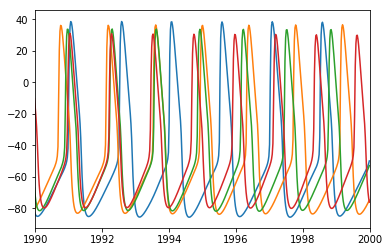

In [54]:

plot(mon_v.t/ms,mon_v[0].v/mV)

plot(mon_v.t/ms,mon_v[1].v/mV)
plot(mon_v.t/ms,mon_v[2].v/mV)
plot(mon_v.t/ms,mon_v[3].v/mV)



# plot(Me.t/ms,Me[2].v/mV)

# legend()
plt.xlim(1990,2000)
# plt.xlim(5,15)


# Me.v.shape

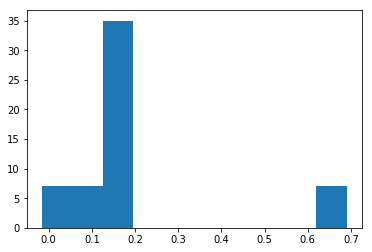

In [55]:
test_w =np.transpose(mon.w)

i = 49999
n, bins, patches = plt.hist(test_w[i][:])
plt.show()

In [22]:
test_w[1499]

array([0.09625994, 0.07693987, 0.08083712, 0.0817135 , 0.08206203,
       0.08223734, 0.08233259, 0.09810262, 0.07693987, 0.08083712,
       0.0817135 , 0.08206203, 0.08223734, 0.08233259, 0.09810262,
       0.09625994, 0.08083712, 0.0817135 , 0.08206203, 0.08223734,
       0.08233259, 0.09810262, 0.09625994, 0.07693987, 0.0817135 ,
       0.08206203, 0.08223734, 0.08233259, 0.09810262, 0.09625994,
       0.07693987, 0.08083712, 0.08206203, 0.08223734, 0.08233259,
       0.09810262, 0.09625994, 0.07693987, 0.08083712, 0.0817135 ,
       0.08223734, 0.08233259, 0.09810262, 0.09625994, 0.07693987,
       0.08083712, 0.0817135 , 0.08206203, 0.08233259, 0.09810262,
       0.09625994, 0.07693987, 0.08083712, 0.0817135 , 0.08206203,
       0.08223734])

Text(0,0.5,'w')

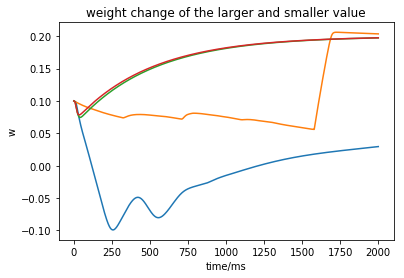

In [56]:
plot(mon.t/ms,mon.w[1])
plot(mon.t/ms,mon.w[0])
plot(mon.t/ms,mon.w[2])
plot(mon.t/ms,mon.w[3])



title('weight change of the larger and smaller value')
xlabel('time/ms')
ylabel('w')

In [36]:
test_w[i][:]

array([0.71084095, 0.30486326, 0.30488349, 0.30490198, 0.30491279,
       0.3049162 , 0.30491779, 0.78509237, 0.30486326, 0.30488349,
       0.30490198, 0.30491279, 0.3049162 , 0.30491779, 0.78509237,
       0.71084095, 0.30488349, 0.30490198, 0.30491279, 0.3049162 ,
       0.30491779, 0.78509237, 0.71084095, 0.30486326, 0.30490198,
       0.30491279, 0.3049162 , 0.30491779, 0.78509237, 0.71084095,
       0.30486326, 0.30488349, 0.30491279, 0.3049162 , 0.30491779,
       0.78509237, 0.71084095, 0.30486326, 0.30488349, 0.30490198,
       0.3049162 , 0.30491779, 0.78509237, 0.71084095, 0.30486326,
       0.30488349, 0.30490198, 0.30491279, 0.30491779, 0.78509237,
       0.71084095, 0.30486326, 0.30488349, 0.30490198, 0.30491279,
       0.3049162 ])

### code coms from pdf 5.14.8 Example: state_variables

Text(0.5,1,'Synaptic weight')

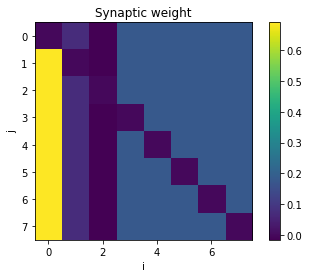

In [57]:
i=49999

w_test = np.zeros((Ne,Ne))
w_test[C_STDP_E.i[:],C_STDP_E.j[:]]=test_w[i][:]
imshow(w_test)
colorbar()
xlabel('i')
ylabel('j')
title('Synaptic weight')

In [39]:
print(C_STDP_E.i[:])
print(C_STDP_E.j[:])
print(test_w[i][:])

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7]
[1 2 3 4 5 6 7 0 2 3 4 5 6 7 0 1 3 4 5 6 7 0 1 2 4 5 6 7 0 1 2 3 5 6 7 0 1
 2 3 4 6 7 0 1 2 3 4 5 7 0 1 2 3 4 5 6]
[ 0.07512685 -0.01499288  0.18124537  0.18208982  0.18238043  0.18253371
  0.18262462  0.68981804 -0.01499288  0.18124537  0.18208982  0.18238043
  0.18253371  0.18262462  0.68981804  0.07512685  0.18124537  0.18208982
  0.18238043  0.18253371  0.18262462  0.68981804  0.07512685 -0.01499288
  0.18208982  0.18238043  0.18253371  0.18262462  0.68981804  0.07512685
 -0.01499288  0.18124537  0.18238043  0.18253371  0.18262462  0.68981804
  0.07512685 -0.01499288  0.18124537  0.18208982  0.18253371  0.18262462
  0.68981804  0.07512685 -0.01499288  0.18124537  0.18208982  0.18238043
  0.18262462  0.68981804  0.07512685 -0.01499288  0.18124537  0.18208982
  0.18238043  0.18253371]


In [18]:
w_test

array([[0.        , 0.03198383, 0.1499289 , 0.16126065, 0.16347412,
        0.16465558, 0.1653505 , 0.16584852],
       [0.545228  , 0.        , 0.1499289 , 0.16126065, 0.16347412,
        0.16465558, 0.1653505 , 0.16584852],
       [0.545228  , 0.03198383, 0.        , 0.16126065, 0.16347412,
        0.16465558, 0.1653505 , 0.16584852],
       [0.545228  , 0.03198383, 0.1499289 , 0.        , 0.16347412,
        0.16465558, 0.1653505 , 0.16584852],
       [0.545228  , 0.03198383, 0.1499289 , 0.16126065, 0.        ,
        0.16465558, 0.1653505 , 0.16584852],
       [0.545228  , 0.03198383, 0.1499289 , 0.16126065, 0.16347412,
        0.        , 0.1653505 , 0.16584852],
       [0.545228  , 0.03198383, 0.1499289 , 0.16126065, 0.16347412,
        0.16465558, 0.        , 0.16584852],
       [0.545228  , 0.03198383, 0.1499289 , 0.16126065, 0.16347412,
        0.16465558, 0.1653505 , 0.        ]])

## E-I have NMDA (STDP)

In [ ]:
start_scope()

defaultclock.dt = 0.02*ms

Ne = 8
Ni = 2
V_I = -80*mV
V_E = 0*mV



# NMDA (excitatory)
g_NMDA_E = 1.0/(Ne-1)*msiemens/cm**2
# g_NMDA_I = 0.258 * nS * 800. / N_E
tausnmdar = 1*ms
tausnmdad = 100*ms
Mg2 = 1.

# some calcium-related vars, table 2
pHC = 4*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6*umolar
thetab = 0.55*umolar
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01*umolar
sigmab = -0.02*umolar
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phi = 0.01
beta = 0.083/ms
chi0 = 0.05*umolar
nbuff = 6.



# E cells stats
Cme = 1*ufarad/cm**2
Ele = -67*mV
ENae = 50*mV
EKe = -100*mV
gle = 0.1*msiemens/cm**2
gNae = 100*msiemens/cm**2
gKe = 80*msiemens/cm**2

# AMPA E-E
gampae = 1.0/(Ne-1)*msiemens/cm**2
ggabae = 0.6/(Ni)*msiemens/cm**2

eqse = '''
dv/dt = ( (gle * (Ele-v) + gNae * m**3 * h * (ENae-v) + gKe * n**4 * (EKe-v) + Isyn + I_NMDA_rec + I))/Cme : volt
Isyn = Iampa + Igaba : amp*meter**-2
Iampa = gampae * (V_E - v) * sampa_tot : amp*meter**-2
Igaba = ggabae * (V_I - v) * sgaba_tot : amp*meter**-2
sampa_tot : 1
sgaba_tot: 1
I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
s_NMDA_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1)/ms : Hz
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)/ms : Hz
alphah = (0.128) * exp(-(v+50*mV)/(18*mV))/ms : Hz
betah = 4/(exp((-v-27*mV) / (5*mV)) + 1)/ms : Hz
alphan = (0.032/mV) * (v+52*mV) / (-exp(-(v+52*mV) / (5*mV)) + 1)/ms : Hz
betan = 0.5*exp(-(v+57*mV)/(40*mV))/ms : Hz

#chi : mmolar
dchi/dt = phi*I_NMDA_rec/(uA/cm**2)*mmolar/ms - beta*(chi-chi0) -(beta/nbuff)*chi**2/mmolar : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((chi-thetab)/sigmab)) -B-Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((chi-thetad)/sigmad)) -D)/taud : 1
'''

Ecells = NeuronGroup(Ne, eqse, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')
Ecells.v = -60*mV

# Me = StateMonitor(Ecells, 'v', record=True)



# ---------------- I cells ---------------- #
Cmi = 1*ufarad/cm**2
Eli = -65*mV
ENai = 55*mV
EKi = -90*mV
gli = 0.1*msiemens/cm**2
gNai = 35*msiemens/cm**2
gKi = 9*msiemens/cm**2
g_NMDA_I = 1.0/(Ne-1)*msiemens/cm**2


# -I synapses
gampai = 0.6/(Ne)*msiemens/cm**2
ggabai = 0.2/(Ni-1)*msiemens/cm**2

eqsi = '''
dv/dt = ( (gli * (Eli-v) + gNai * m**3 * h * (ENai-v) + gKi * n**4 * (EKi-v) + Isyn + I_NMDA_rec + I))/Cmi : volt
#Isyn = Igaba : amp*meter**-2
Isyn = Igaba + Iampa : amp*meter**-2
Igaba = ggabai * (V_I - v) * sgaba_tot : amp*meter**-2
Iampa = gampai * (V_E - v) * sampa_tot : amp*meter**-2
sampa_tot : 1
sgaba_tot : 1
I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp*meter**-2
s_NMDA_tot : 1
I : amp*meter**-2
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * (v+35*mV) / (-exp((-v-35*mV) / (10*mV)) + 1)/ms : Hz
betam = 4 * exp(-(v+60*mV)/(18*mV))/ms : Hz
alphah = (0.35) * exp(-(v+58*mV)/(20*mV))/ms : Hz
betah = 5/(exp((-v-28*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.05/mV) * (v+34*mV) / (-exp(-(v+34*mV) / (10*mV)) + 1)/ms : Hz
betan = (0.625)*exp(-(v+44*mV)/(80*mV))/ms : Hz
'''

Icells = NeuronGroup(Ni, eqsi, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')
Icells.v = -60*mV


# ---------------- Initialization ---------------- #
Ecells.P = 0.
Ecells.A = 0.
Ecells.V = 0.
Ecells.B = 0.
Ecells.D = 0.
Ecells.I = linspace(0.1,5,(Ne))*amp*meter**-2
Ecells.chi = 0.06*umolar

# ---------------- Synapses ---------------- #

tausampar = 0.2*ms
tausampad = 2*ms
tausgabar = 0.5*ms
tausgabad = 10*ms

alphaw = 0.8
betaw = 0.6
tauw = 500*ms


eqs_nmda  = ''' 
#w : 1 # synaptic weight
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = (1+tanh(v_pre/mV/10))/2 * (1-s_NMDA)/tausnmdar - s_NMDA/tausnmdad : 1 (clock-driven)
dw/dt = ( alphaw/(1+exp((P-p)/kp)) - betaw/(1+exp((D-d)/kd)) - w )/tauw :1 (clock-driven)
'''

# E-E NMDA
C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
                 method='rk4')
C_STDP_E.connect(condition='i != j')
C_STDP_E.w[:] = 1

# # E-I NMDA
# C_STDP_E = Synapses(Ecells, Ecells, model=eqs_nmda, 
#                  method='rk4')
# C_STDP.connect(condition='i != j')
# C_STDP.w[:] = 1


eqs_ampa  = ''' 
sampa_tot_post = sampa : 1 (summed)
dsampa/dt= (1+tanh(v_pre/mV/10))/2 * (1-sampa)/tausampar - sampa/tausampad : 1 (clock-driven)
w : 1 # synaptic weight
'''

eqs_gaba  = ''' 
sgaba_tot_post = sgaba : 1 (summed)
dsgaba/dt= (1+tanh(v_pre/mV/10))/2 * (1-sgaba)/tausgabar - sgaba/tausgabad : 1 (clock-driven)
w : 1 # synaptic weight
'''

# ----------------
# E-E AMPA
C_E_E_AMPA = Synapses(Ecells, Ecells, model=eqs_ampa, method='rk4')
C_E_E_AMPA.connect('i != j')

# E-I, ampa
C_E_I = Synapses(Ecells, Icells, model=eqs_ampa, method='rk4')
C_E_I.connect()

# I-I GABA
C_I_I = Synapses(Icells, Icells, model=eqs_gaba, method='rk4')
C_I_I.connect('i != j')
C_I_I.connect()


# I-E GABA
C_I_E = Synapses(Icells, Ecells, model=eqs_gaba, method='rk4')
C_I_E.connect()



